<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import missingno as msno
from pprint import pprint
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, train_test_split
from sklearn.feature_selection import RFECV, mutual_info_regression
from sklearn import metrics

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

## Loading and Cleaning the Data
1. Load the data
2. Remove Non - Residential properties from the data set as instructed
3. Look at NA values and decide what to do with each of them 
4. Check data types and fix any that don't match the data


##### Load the data

In [3]:
house = pd.read_csv('../housing.csv')

In [4]:
house.shape

(1460, 81)

In [5]:
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

##### Remove non-residential zoned houses

In [7]:

house.drop(house[house['MSZoning']=='C (all)'].index, axis=0, inplace=True)

In [8]:
house.MSZoning.value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

##### Creation of a function to fill in the na values of specified columns

In [9]:
def fill(col_list,fill_value):
    for col in col_list:
        house.loc[:, col] = house.loc[:, col].fillna(fill_value)

In [10]:
fill_none = ['Alley','MiscFeature','GarageType','GarageQual','GarageCond','GarageFinish','PoolQC',
             'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','MasVnrType','FireplaceQu']

In [11]:
fill(fill_none,'None')

In [12]:
fill(['Fence'],'No')

In [13]:
fill_zero = ['MiscVal','MasVnrArea']
fill(fill_zero,0)

In [14]:
fill(['GarageYrBlt'],np.nan)

##### As there is only one NA for Electrical and no clear way of filling it, I have decided to drop the row containing this NA

In [15]:
house.drop(house[house['Electrical'].isna()].index, axis=0, inplace=True)

In [16]:
house.iloc[:,0:-1][house['LotFrontage'].isna()].head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,0,None,No,Shed,350,11,2009,WD,Normal
12,13,20,RL,NaN,12968,Pave,None,IR2,Lvl,AllPub,...,176,0,None,No,None,0,9,2008,WD,Normal
14,15,20,RL,NaN,10920,Pave,None,IR1,Lvl,AllPub,...,0,0,None,GdWo,None,0,5,2008,WD,Normal
16,17,20,RL,NaN,11241,Pave,None,IR1,Lvl,AllPub,...,0,0,None,No,Shed,700,3,2010,WD,Normal
24,25,20,RL,NaN,8246,Pave,None,IR1,Lvl,AllPub,...,0,0,None,MnPrv,None,0,5,2010,WD,Normal


##### From looking at the LotConfig, BldgType and Foundation of the NA LotFrontage, I have concluded this should not be zero value and should be replaced with a numerical value of some sorts

/Applications/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:2410: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(data[col].dropna().values, bins=bins, **kwds)
/Applications/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:2410: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(data[col].dropna().values, bins=bins, **kwds)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1d0ba9b0>]],
      dtype=object)

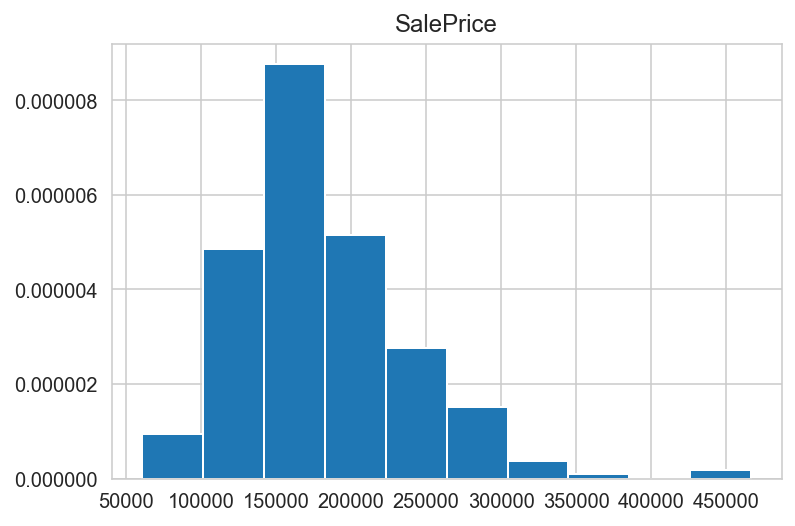

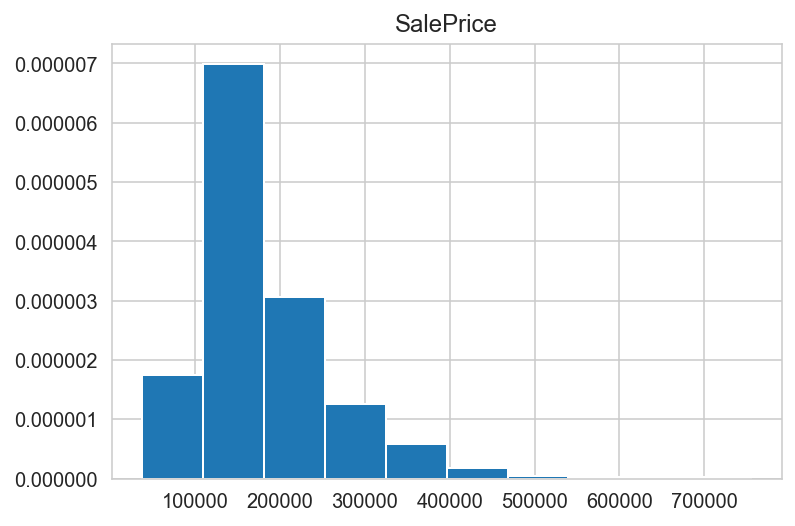

In [17]:
house[house['LotFrontage'].isna()][['SalePrice']].hist(normed=True)
house[~house['LotFrontage'].isna()][['SalePrice']].hist(normed=True)

##### As the distribution of LotFrontage against SalePrice is significantly different between the values we do have and the values we don't, this needs to be imputed using a model

In [18]:
target = house[~house['LotFrontage'].isna()][['LotFrontage']]

##### Features selected by using the model and adjusting features until the p values and the R2 are good

In [19]:
feature = house[['1stFlrSF', 'LotArea', 'GrLivArea', 'TotRmsAbvGrd','GarageArea','GarageCars']]

In [20]:
(house.corrwith(house['LotFrontage']).sort_values(ascending=False)>0.2)

LotFrontage       True
1stFlrSF          True
LotArea           True
GrLivArea         True
TotalBsmtSF       True
SalePrice         True
TotRmsAbvGrd      True
GarageArea        True
GarageCars        True
Fireplaces        True
BedroomAbvGr      True
OverallQual       True
BsmtFinSF1        True
PoolArea          True
FullBath          True
MasVnrArea       False
OpenPorchSF      False
BsmtUnfSF        False
YearBuilt        False
BsmtFullBath     False
WoodDeckSF       False
YearRemodAdd     False
2ndFlrSF         False
3SsnPorch        False
GarageYrBlt      False
HalfBath         False
BsmtFinSF2       False
ScreenPorch      False
LowQualFinSF     False
EnclosedPorch    False
MoSold           False
YrSold           False
MiscVal          False
KitchenAbvGr     False
BsmtHalfBath     False
Id               False
OverallCond      False
MSSubClass       False
dtype: bool

In [21]:
data = feature.copy()

# data['feature']=feature
data['target']=target
data.head()

,1stFlrSF,LotArea,GrLivArea,TotRmsAbvGrd,GarageArea,GarageCars,target
0,856,8450,1710,8,548,2,65.0
1,1262,9600,1262,6,460,2,80.0
2,920,11250,1786,6,608,2,68.0
3,961,9550,1717,7,642,3,60.0
4,1145,14260,2198,9,836,3,84.0


In [22]:
data.dropna(inplace=True)

In [23]:
model = sm.OLS(data['target'], data[feature.columns])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     2354.
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        08:27:34   Log-Likelihood:                -5289.8
No. Observations:                1190   AIC:                         1.059e+04
Df Residuals:                    1184   BIC:                         1.062e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
1stFlrSF         0.0218      0.002     11.426      0.000       0.018       0.026
LotArea          0.0009   8.12e-05     10.593      0.000       0.001       0.001
GrLivArea       -0.0063      0.002     -2.928      0.003      -0.011      -0.002
TotRmsAbvGrd     5.9482      0.497     11.975      0.000       4.974       6.923
GarageArea       0.0247      0.006      3.961      0.000       0.012       0.037
GarageCars      -3.4097      1.720     -1.983      0.048      -6.784      -0.036
==============================================================================
Omnibus:                      377.013   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5676.916
Skew:                           1.040   Prob(JB):                         0.00
Kurtosis:                      13.496   Cond. No.                     3.69e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Predict the values of the Lot Frontage NAs and fill the column

In [24]:
house.loc[house.LotFrontage.isna(),'LotFrontage'] = results.predict(house[house.LotFrontage.isna()][model.exog_names])


In [25]:
house.LotFrontage.isna().any()

False

In [26]:
print(list(house.isna().sum()>0))

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


##### Inspect the datatypes of columns

In [27]:
print(dict(house.dtypes))

{'Id': dtype('int64'), 'MSSubClass': dtype('int64'), 'MSZoning': dtype('O'), 'LotFrontage': dtype('float64'), 'LotArea': dtype('int64'), 'Street': dtype('O'), 'Alley': dtype('O'), 'LotShape': dtype('O'), 'LandContour': dtype('O'), 'Utilities': dtype('O'), 'LotConfig': dtype('O'), 'LandSlope': dtype('O'), 'Neighborhood': dtype('O'), 'Condition1': dtype('O'), 'Condition2': dtype('O'), 'BldgType': dtype('O'), 'HouseStyle': dtype('O'), 'OverallQual': dtype('int64'), 'OverallCond': dtype('int64'), 'YearBuilt': dtype('int64'), 'YearRemodAdd': dtype('int64'), 'RoofStyle': dtype('O'), 'RoofMatl': dtype('O'), 'Exterior1st': dtype('O'), 'Exterior2nd': dtype('O'), 'MasVnrType': dtype('O'), 'MasVnrArea': dtype('float64'), 'ExterQual': dtype('O'), 'ExterCond': dtype('O'), 'Foundation': dtype('O'), 'BsmtQual': dtype('O'), 'BsmtCond': dtype('O'), 'BsmtExposure': dtype('O'), 'BsmtFinType1': dtype('O'), 'BsmtFinSF1': dtype('int64'), 'BsmtFinType2': dtype('O'), 'BsmtFinSF2': dtype('int64'), 'BsmtUnfSF':

In [28]:
house.MSSubClass.unique()

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
       180,  40])

##### Change MSSubClass to object

In [29]:
for n in house.MSSubClass.unique():
    house = house.replace({"MSSubClass" : {n : "MSC"+str(n)}})

In [30]:
house.MSSubClass.dtype

dtype('O')

##### Change to numberic ratings: 
'ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive','PoolQC', 'Fence'

In [31]:
var3 = ['PavedDrive']
var4 = ['GarageFinish']
var5 = ['Fence']
var6 = ['ExterQual','ExterCond','BsmtQual','BsmtCond',
        'HeatingQC','KitchenQual','FireplaceQu',
        'GarageQual','GarageCond','PoolQC']
var7 = ['BsmtFinType1','BsmtFinType2']    
var8 = ['Functional']

In [32]:
house.FireplaceQu.unique()

array(['None', 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [33]:
for col in var3:
    house = house.replace({col : {'Y': 2, 'N': 1, 'P': 0}})                      
for col in var4:
    house = house.replace({col : {'RFn': 2, 'Unf': 1, 'Fin': 3, 'None': 0}})
for col in var5:
    house = house.replace({col : {'No': 0, 'MnPrv': 3, 'GdWo': 2, 'GdPrv': 4, 'MnWw': 1}})
for col in var6:
    house = house.replace({col : {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}})
for col in var7:    
    house = house.replace({col : {'GLQ': 6, 'ALQ': 5, 'Unf': 1, 'Rec': 3, 'BLQ': 4, 'None': 0, 'LwQ': 2}})
for col in var8:
    house = house.replace({col : {'Typ': 7, 'Min1': 6, 'Maj1': 3, 'Min2': 5, 'Mod': 4, 'Maj2': 2, 'Sev': 1}}) 

In [34]:
house.FireplaceQu.unique()

array([0, 3, 4, 2, 5, 1])

In [35]:
house.dtypes

Id                 int64
MSSubClass        object
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional         int64
Fireplaces         int64
FireplaceQu        int64
GarageType        object
GarageYrBlt      float64


##### Creation of age variables to deal with year columns

In [36]:
house['HouseAge']= house['YrSold']-house['YearBuilt']
house['RemodelAge']= house['YrSold']-house['YearRemodAdd']
house['GarageAge']= house['YrSold']-house['GarageYrBlt']

##### Rename inaccurate column name

In [37]:
house.rename(columns={'BsmtQual':'BsmtHeight'}, inplace=True)

## EDA
1. Check out statistics
2. Look for outliers
3. Create training and testing split data
4. Identify fixed variables
5. Investigate correlations of the numerical variables

In [38]:
house.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1449.0,730.916494,421.354997,1.0,366.00000,731.0,1096.0,1460.0
LotFrontage,1449.0,70.292821,23.845300,21.0,59.22505,69.0,80.0,313.0
LotArea,1449.0,10524.376121,10015.620536,1300.0,7540.00000,9492.0,11616.0,215245.0
OverallQual,1449.0,6.115252,1.373022,1.0,5.00000,6.0,7.0,10.0
OverallCond,1449.0,5.582471,1.107606,1.0,5.00000,5.0,6.0,9.0
YearBuilt,1449.0,1971.569358,30.019438,1872.0,1954.00000,1973.0,2001.0,2010.0
YearRemodAdd,1449.0,1985.034507,20.551315,1950.0,1967.00000,1994.0,2004.0,2010.0
MasVnrArea,1449.0,103.899931,181.192098,0.0,0.00000,0.0,166.0,1600.0
BsmtHeight,1449.0,3.492063,0.878754,0.0,3.00000,4.0,4.0,5.0
BsmtCond,1449.0,2.935818,0.553137,0.0,3.00000,3.0,3.0,4.0


##### Investigation of odd looking max values / std

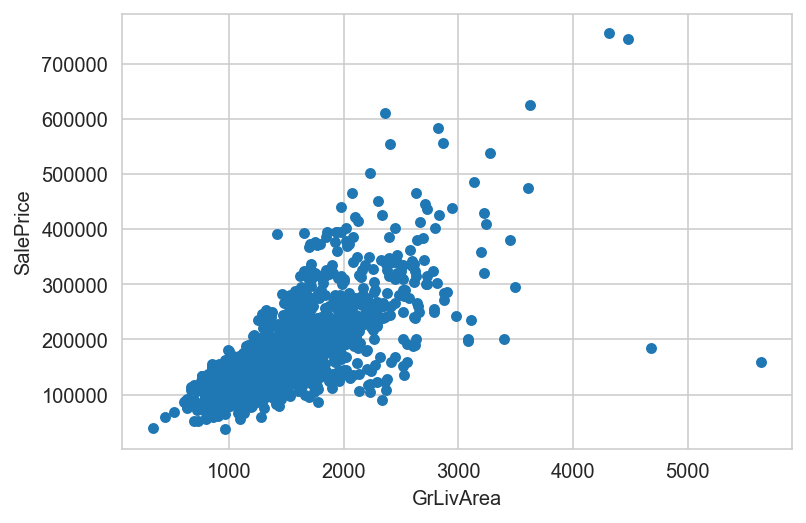

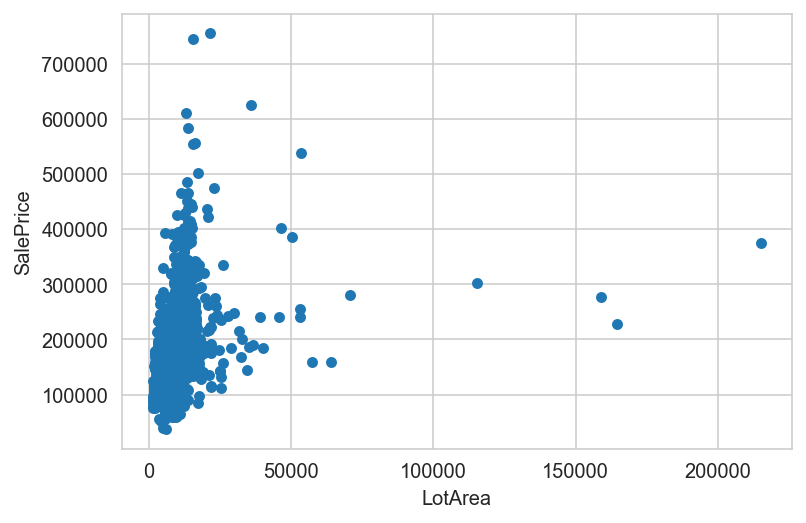

In [39]:
house.plot(kind= 'scatter', x='GrLivArea',y='SalePrice')
house.plot(kind= 'scatter', x='LotArea',y='SalePrice')

##### Remove outliers

In [40]:
house = house[house.GrLivArea < 4500]
house = house[house.LotArea < 100000]

In [41]:
house.shape

(1443, 84)

##### Split into training and testing data

In [42]:
house_train = house[house.YrSold < 2010]
house_test = house[house.YrSold >= 2010]
y_train = house_train['SalePrice']
X_train = house_train.drop(columns = 'SalePrice', axis = 1)
y_test = house_test['SalePrice']
X_test = house_test.drop(columns = 'SalePrice', axis = 1)

In [43]:
X_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,HouseAge,RemodelAge,GarageAge
16,17,MSC20,RL,60.059053,11241,Pave,None,IR1,Lvl,AllPub,...,0,Shed,700,3,2010,WD,Normal,40,40,40.0
24,25,MSC20,RL,62.511732,8246,Pave,None,IR1,Lvl,AllPub,...,3,None,0,5,2010,WD,Normal,42,9,42.0
26,27,MSC20,RL,60.000000,7200,Pave,None,Reg,Lvl,AllPub,...,0,None,0,5,2010,WD,Normal,59,10,5.0
27,28,MSC20,RL,98.000000,11478,Pave,None,Reg,Lvl,AllPub,...,0,None,0,5,2010,WD,Normal,3,2,2.0
33,34,MSC20,RL,70.000000,10552,Pave,None,IR1,Lvl,AllPub,...,0,None,0,4,2010,WD,Normal,51,51,51.0


In [44]:
fixed = house[['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','LotShape','LandContour','Utilities'
              ,'LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType', 'HouseStyle', 
              'HouseAge', 'RemodelAge', 'Foundation', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
             'Heating', '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','Fireplaces',
             'GarageType','GarageCars','GarageArea','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
              'ScreenPorch', 'PoolArea','SalePrice','TotalBsmtSF','BsmtHeight']]

In [45]:
fixed.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,SalePrice,TotalBsmtSF,BsmtHeight
0,MSC60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,548,0,61,0,0,0,0,208500,856,4
1,MSC20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,460,298,0,0,0,0,0,181500,1262,4
2,MSC60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,608,0,42,0,0,0,0,223500,920,4
3,MSC70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,642,0,35,272,0,0,0,140000,756,3
4,MSC60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,836,192,84,0,0,0,0,250000,1145,4


##### Separate out the categorical and numerical variables

In [46]:
fixed_cat = fixed.select_dtypes(include = 'object').copy()
fixed_num = fixed.select_dtypes(include = ['int64','float64']).copy()

##### Find correlations of numerical values with price

In [47]:
corr = dict(fixed_num.corrwith(fixed['SalePrice']).sort_values(ascending=False))
corr

{'SalePrice': 1.0,
 'GrLivArea': 0.7350361445520032,
 'TotalBsmtSF': 0.647805540787152,
 'GarageCars': 0.6439559373304289,
 'GarageArea': 0.6369962241045544,
 '1stFlrSF': 0.6267869104419892,
 'BsmtHeight': 0.5867362337461142,
 'Fireplaces': 0.46224049728853966,
 'BsmtFinSF1': 0.404204228324512,
 'LotFrontage': 0.3918062524258958,
 'LotArea': 0.37341954810186634,
 'OpenPorchSF': 0.33741865775074553,
 '2ndFlrSF': 0.32417600294064614,
 'WoodDeckSF': 0.3229203420401587,
 'BsmtFullBath': 0.22081951336208536,
 'BsmtUnfSF': 0.2193582316381908,
 'ScreenPorch': 0.11195694083036126,
 'PoolArea': 0.1001754377935465,
 '3SsnPorch': 0.04439851692062384,
 'LowQualFinSF': -0.01838338452041277,
 'BsmtHalfBath': -0.020352837642202477,
 'BsmtFinSF2': -0.022259642612114595,
 'EnclosedPorch': -0.11991065711853273,
 'RemodelAge': -0.506867028356885,
 'HouseAge': -0.5218632221576593}

##### Filtering out correlations with a magnitude less than 0.4

In [48]:
fixed_num_corr = pd.DataFrame(data = [fixed_num[k] for k,v in corr.items() if v>0.4 or v<-0.4]).T
fixed_num_corr.head()

,SalePrice,GrLivArea,TotalBsmtSF,GarageCars,GarageArea,1stFlrSF,BsmtHeight,Fireplaces,BsmtFinSF1,RemodelAge,HouseAge
0,208500,1710,856,2,548,856,4,0,706,5,5
1,181500,1262,1262,2,460,1262,4,1,978,31,31
2,223500,1786,920,2,608,920,4,1,486,6,7
3,140000,1717,756,3,642,961,3,1,216,36,91
4,250000,2198,1145,3,836,1145,4,1,655,8,8


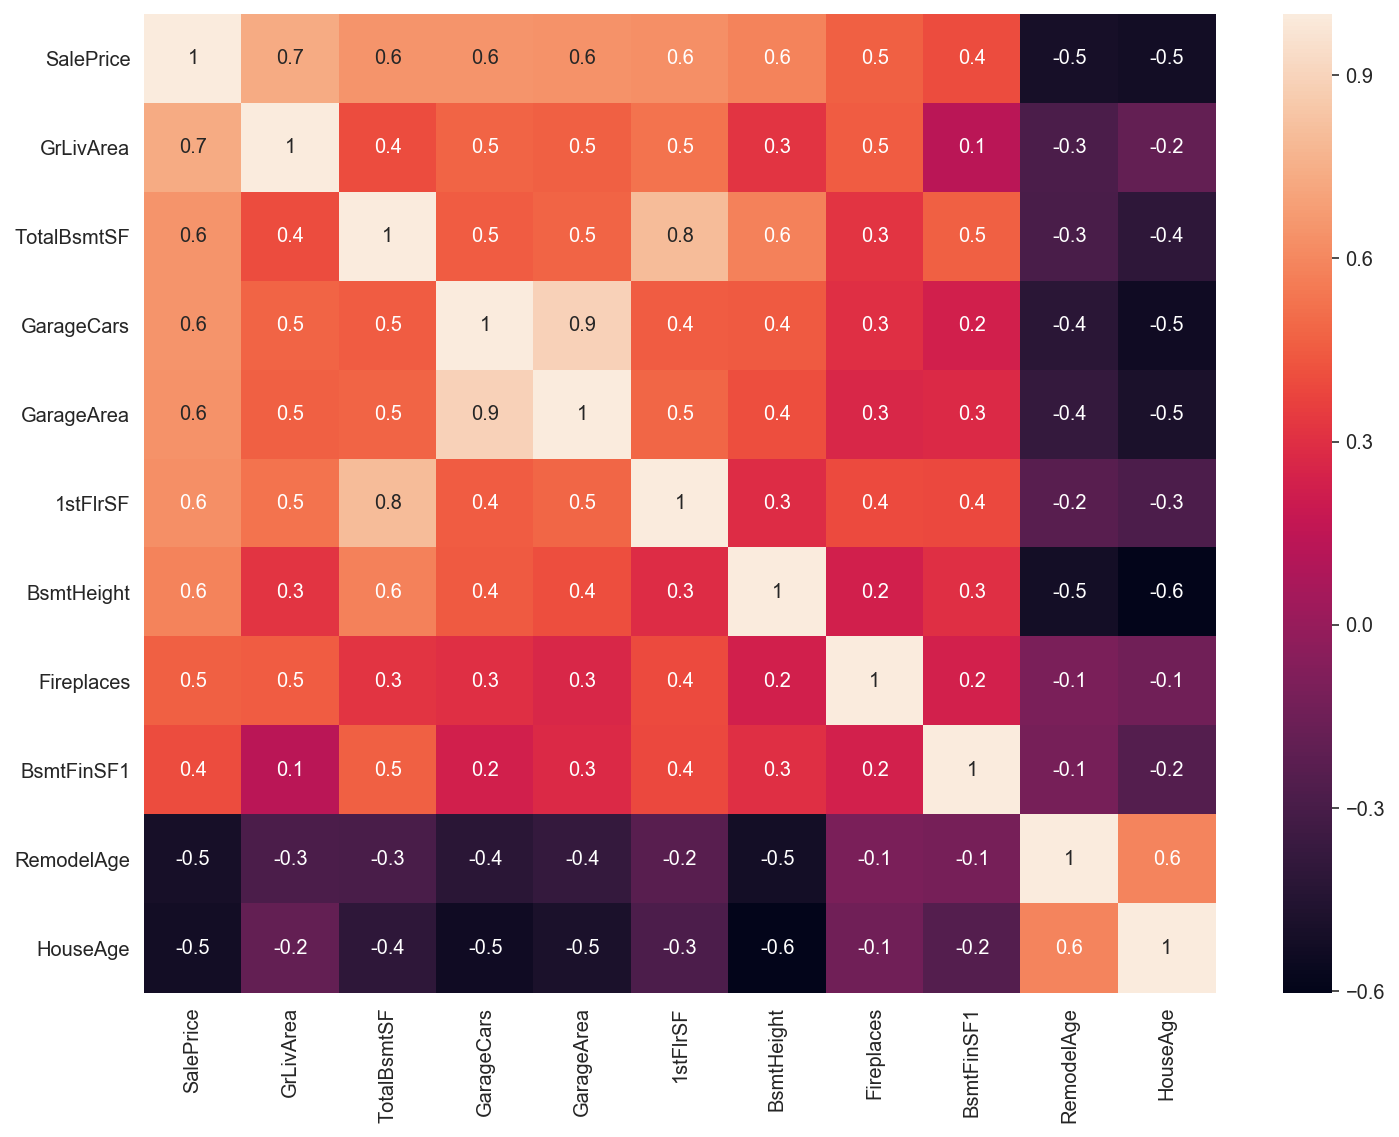

In [49]:
plt.figure(figsize=(12, 9))
sns.heatmap(fixed_num_corr.corr(), annot=True, fmt='0.1g')

 ##### Notes on correlation heatmap:
 - don't use GarageCars due to high correlation with GarageArea and lower variance
 - don't use RemodelAge due to high correlation with HouseAge and lower correlation with SalePrice
 - don't use 1stFlrSF due to high correlation with GrLivArea and TotalBsmtSF and lower correlation with SalePrice
 - don't use BsmtFinSF1 as its definition overlaps with TotalBsmtSF

##### Check out the variations in Neighbourhoods

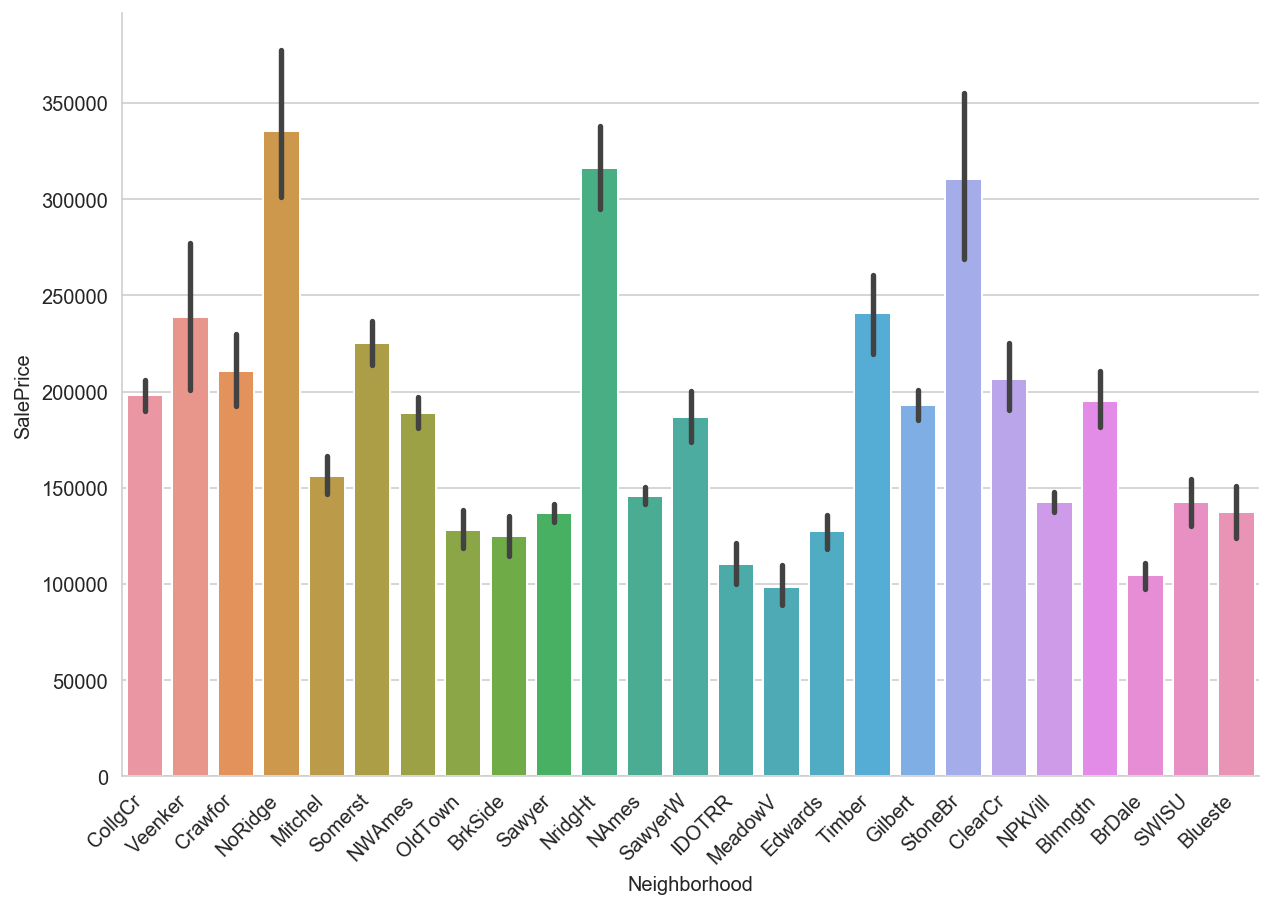

In [50]:
sns.catplot(x='Neighborhood', y='SalePrice', data=house, kind='bar', height = 6, aspect = 1.5).set_xticklabels(rotation=45, horizontalalignment='right')


In [51]:
fixed.Neighborhood.value_counts()

NAmes      225
CollgCr    150
OldTown    112
Edwards     98
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      35
IDOTRR      28
ClearCr     26
SWISU       25
StoneBr     25
Blmngtn     17
MeadowV     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

 - good variation so will most likely be good to use in the model

## Modelling
1. Look at some basic models
2. Play around using different variables selected above to find the best fit
3. Plot and evaluate final model

In [52]:
model1 = smf.ols(formula ="SalePrice ~ C(Neighborhood)", data= house_train).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     62.00
Date:                Mon, 29 Jul 2019   Prob (F-statistic):          4.66e-193
Time:                        08:27:40   Log-Likelihood:                -15637.
No. Observations:                1271   AIC:                         3.132e+04
Df Residuals:                    1246   BIC:                         3.145e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   1.951e+05   1.35e+04     14.491      0.000    1.69e+05    2.21e+05
C(Neighborhood)[T.Blueste] -5.755e+04   4.04e+04     -1.425      0.154   -1.37e+05    2.17e+04
C(Neighborhood)[T.BrDale]  -8.946e+04   1.94e+04     -4.623      0.000   -1.27e+05   -5.15e+04
C(Neighborhood)[T.BrkSide]  -6.92e+04   1.53e+04     -4.534      0.000   -9.91e+04   -3.93e+04
C(Neighborhood)[T.ClearCr]  4287.5057   1.77e+04      0.242      0.809   -3.04e+04     3.9e+04
C(Neighborhood)[T.CollgCr]  2371.3371   1.42e+04      0.167      0.868   -2.55e+04    3.03e+04
C(Neighborhood)[T.Crawfor]  1.019e+04   1.55e+04      0.655      0.512   -2.03e+04    4.07e+04
C(Neighborhood)[T.Edwards] -6.572e+04   1.46e+04     -4.488      0.000   -9.45e+04    -3.7e+04
C(Neighborhood)[T.Gilbert] -1591.3262   1.49e+04     -0.107      0.915   -3.07e+04    2.76e+04
C(Neighborhood)[T.IDOTRR]  -8.294e+04   1.72e+04     -4.812      0.000   -1.17e+05   -4.91e+04
C(Neighborhood)[T.MeadowV] -9.278e+04   1.97e+04     -4.709      0.000   -1.31e+05   -5.41e+04
C(Neighborhood)[T.Mitchel] -3.973e+04   1.57e+04     -2.535      0.011   -7.05e+04   -8984.291
C(Neighborhood)[T.NAmes]   -5.055e+04    1.4e+04     -3.608      0.000    -7.8e+04   -2.31e+04
C(Neighborhood)[T.NPkVill] -5.066e+04   2.44e+04     -2.076      0.038   -9.85e+04   -2790.714
C(Neighborhood)[T.NWAmes]  -5828.2670    1.5e+04     -0.388      0.698   -3.53e+04    2.36e+04
C(Neighborhood)[T.NoRidge]  1.496e+05   1.63e+04      9.164      0.000    1.18e+05    1.82e+05
C(Neighborhood)[T.NridgHt]  1.221e+05   1.49e+04      8.176      0.000    9.28e+04    1.51e+05
C(Neighborhood)[T.OldTown] -6.606e+04   1.45e+04     -4.550      0.000   -9.45e+04   -3.76e+04
C(Neighborhood)[T.SWISU]   -5.229e+04   1.77e+04     -2.956      0.003    -8.7e+04   -1.76e+04
C(Neighborhood)[T.Sawyer]  -5.705e+04   1.52e+04     -3.752      0.000   -8.69e+04   -2.72e+04
C(Neighborhood)[T.SawyerW] -7793.9647   1.56e+04     -0.499      0.618   -3.85e+04    2.29e+04
C(Neighborhood)[T.Somerst]  3.224e+04   1.48e+04      2.182      0.029    3249.838    6.12e+04
C(Neighborhood)[T.StoneBr]  1.134e+05   1.81e+04      6.277      0.000    7.79e+04    1.49e+05
C(Neighborhood)[T.Timber]   4.522e+04   1.67e+04      2.713      0.007    1.25e+04    7.79e+04
C(Neighborhood)[T.Veenker]  4.372e+04   2.11e+04      2.073      0.038    2350.606    8.51e+04
==============================================================================
Omnibus:                      548.413   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4876.485
Skew:                           1.767   Prob(JB):                         0.00
Kurtosis:                      11.921   Cond. No.                         47.0
============================

In [53]:
model2 = smf.ols(formula ="SalePrice ~ GrLivArea:Neighborhood", data= house_train).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     185.7
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        08:27:40   Log-Likelihood:                -15149.
No. Observations:                1271   AIC:                         3.035e+04
Df Residuals:                    1245   BIC:                         3.048e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        4.803e+04   3798.430     12.646      0.000    4.06e+04    5.55e+04
GrLivArea:Neighborhood[Blmngtn]   102.5290      6.872     14.920      0.000      89.047     116.011
GrLivArea:Neighborhood[Blueste]    64.4969     18.700      3.449      0.001      27.810     101.184
GrLivArea:Neighborhood[BrDale]     50.3700      8.811      5.717      0.000      33.085      67.655
GrLivArea:Neighborhood[BrkSide]    66.7095      4.806     13.882      0.000      57.282      76.137
GrLivArea:Neighborhood[ClearCr]    81.2462      4.740     17.142      0.000      71.948      90.545
GrLivArea:Neighborhood[CollgCr]   100.7911      3.102     32.487      0.000      94.704     106.878
GrLivArea:Neighborhood[Crawfor]    88.0496      3.450     25.519      0.000      81.281      94.819
GrLivArea:Neighborhood[Edwards]    64.7182      4.054     15.964      0.000      56.765      72.671
GrLivArea:Neighborhood[Gilbert]    88.0977      3.419     25.768      0.000      81.390      94.805
GrLivArea:Neighborhood[IDOTRR]     54.5491      6.771      8.057      0.000      41.266      67.832
GrLivArea:Neighborhood[MeadowV]    47.7594      8.742      5.463      0.000      30.609      64.909
GrLivArea:Neighborhood[Mitchel]    81.6167      4.909     16.626      0.000      71.986      91.247
GrLivArea:Neighborhood[NAmes]      72.5434      3.304     21.959      0.000      66.062      79.025
GrLivArea:Neighborhood[NPkVill]    75.4568     11.295      6.681      0.000      53.298      97.616
GrLivArea:Neighborhood[NWAmes]     80.4150      3.254     24.714      0.000      74.031      86.799
GrLivArea:Neighborhood[NoRidge]   120.0846      2.790     43.044      0.000     114.611     125.558
GrLivArea:Neighborhood[NridgHt]   139.8296      2.905     48.140      0.000     134.131     145.528
GrLivArea:Neighborhood[OldTown]    56.0648      3.192     17.562      0.000      49.802      62.328
GrLivArea:Neighborhood[SWISU]      51.6647      4.534     11.395      0.000      42.769      60.560
GrLivArea:Neighborhood[Sawyer]     71.3953      4.772     14.961      0.000      62.033      80.757
GrLivArea:Neighborhood[SawyerW]    88.1204      3.949     22.316      0.000      80.374      95.867
GrLivArea:Neighborhood[Somerst]   112.5706      3.428     32.840      0.000     105.846     119.296
GrLivArea:Neighborhood[StoneBr]   140.3986      4.632     30.309      0.000     131.311     149.486
GrLivArea:Neighborhood[Timber]    110.0347      4.306     25.555      0.000     101.587     118.482
GrLivArea:Neighborhood[Veenker]   124.7478      7.443     16.760      0.000     110.145     139.351
==============================================================================
Omnibus:                      279.316   Durbin-Watson:                   2.010
Prob(Omnibus):           

 - Good combination. Great p values but R squared value could be better

In [54]:
model3 = smf.ols(formula = 'SalePrice ~ GrLivArea:Neighborhood + GarageArea + Fireplaces', data=house_train).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     203.3
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        08:27:40   Log-Likelihood:                -15063.
No. Observations:                1271   AIC:                         3.018e+04
Df Residuals:                    1243   BIC:                         3.033e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        3.659e+04   3843.624      9.520      0.000    2.91e+04    4.41e+04
GrLivArea:Neighborhood[Blmngtn]    79.2365      6.666     11.887      0.000      66.159      92.314
GrLivArea:Neighborhood[Blueste]    42.3270     17.573      2.409      0.016       7.852      76.802
GrLivArea:Neighborhood[BrDale]     44.2929      8.251      5.368      0.000      28.105      60.481
GrLivArea:Neighborhood[BrkSide]    54.2261      4.607     11.772      0.000      45.189      63.263
GrLivArea:Neighborhood[ClearCr]    63.9204      4.653     13.738      0.000      54.792      73.049
GrLivArea:Neighborhood[CollgCr]    81.5841      3.243     25.159      0.000      75.222      87.946
GrLivArea:Neighborhood[Crawfor]    70.6970      3.537     19.987      0.000      63.758      77.636
GrLivArea:Neighborhood[Edwards]    55.0487      3.870     14.224      0.000      47.456      62.641
GrLivArea:Neighborhood[Gilbert]    70.1968      3.489     20.121      0.000      63.352      77.041
GrLivArea:Neighborhood[IDOTRR]     46.0580      6.382      7.217      0.000      33.538      58.578
GrLivArea:Neighborhood[MeadowV]    34.8634      8.251      4.225      0.000      18.675      51.051
GrLivArea:Neighborhood[Mitchel]    62.0361      4.816     12.882      0.000      52.589      71.484
GrLivArea:Neighborhood[NAmes]      54.8969      3.367     16.302      0.000      48.290      61.503
GrLivArea:Neighborhood[NPkVill]    54.7019     10.683      5.121      0.000      33.744      75.660
GrLivArea:Neighborhood[NWAmes]     61.3369      3.364     18.234      0.000      54.737      67.937
GrLivArea:Neighborhood[NoRidge]   101.3657      2.956     34.288      0.000      95.566     107.166
GrLivArea:Neighborhood[NridgHt]   114.1969      3.321     34.386      0.000     107.681     120.712
GrLivArea:Neighborhood[OldTown]    44.6487      3.106     14.374      0.000      38.554      50.743
GrLivArea:Neighborhood[SWISU]      43.7552      4.308     10.157      0.000      35.304      52.207
GrLivArea:Neighborhood[Sawyer]     54.1604      4.651     11.646      0.000      45.036      63.284
GrLivArea:Neighborhood[SawyerW]    70.3198      3.922     17.929      0.000      62.625      78.015
GrLivArea:Neighborhood[Somerst]    90.6869      3.611     25.112      0.000      83.602      97.772
GrLivArea:Neighborhood[StoneBr]   119.7363      4.595     26.056      0.000     110.721     128.752
GrLivArea:Neighborhood[Timber]     86.1856      4.399     19.591      0.000      77.555      94.816
GrLivArea:Neighborhood[Veenker]    99.2901      7.230     13.733      0.000      85.106     113.474
GarageArea                         60.9584      5.993     10.171      0.000      49.200      72.717
Fireplaces                       1.492e+04   1820.251      8.195      0.000    1.13

 - Again, good combination. Great p values but R squared value could be better

##### Why not just try all variables selected by correlation together

In [55]:
model4 = smf.ols(formula = 'SalePrice ~ GrLivArea:Neighborhood + GarageArea + Fireplaces\
                        + HouseAge + TotalBsmtSF + BsmtHeight', data=house_train).fit()

model4.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     233.8
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        08:27:40   Log-Likelihood:                -14932.
No. Observations:                1271   AIC:                         2.993e+04
Df Residuals:                    1240   BIC:                         3.008e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                        9706.3822   6829.506      1.421      0.155   -3692.281    2.31e+04
GrLivArea:Neighborhood[Blmngtn]    58.1385      6.230      9.332      0.000      45.916      70.361
GrLivArea:Neighborhood[Blueste]    41.3752     15.912      2.600      0.009      10.158      72.592
GrLivArea:Neighborhood[BrDale]     46.5920      7.463      6.243      0.000      31.951      61.233
GrLivArea:Neighborhood[BrkSide]    61.4547      4.567     13.455      0.000      52.494      70.415
GrLivArea:Neighborhood[ClearCr]    58.1998      4.245     13.711      0.000      49.872      66.528
GrLivArea:Neighborhood[CollgCr]    66.9987      3.140     21.337      0.000      60.838      73.159
GrLivArea:Neighborhood[Crawfor]    70.8925      3.373     21.020      0.000      64.276      77.509
GrLivArea:Neighborhood[Edwards]    55.6241      3.553     15.655      0.000      48.653      62.595
GrLivArea:Neighborhood[Gilbert]    61.8597      3.346     18.488      0.000      55.295      68.424
GrLivArea:Neighborhood[IDOTRR]     53.5346      6.128      8.736      0.000      41.513      65.556
GrLivArea:Neighborhood[MeadowV]    32.4736      7.487      4.337      0.000      17.785      47.162
GrLivArea:Neighborhood[Mitchel]    51.5049      4.403     11.697      0.000      42.866      60.143
GrLivArea:Neighborhood[NAmes]      51.9328      3.131     16.585      0.000      45.789      58.076
GrLivArea:Neighborhood[NPkVill]    48.7216      9.664      5.042      0.000      29.762      67.681
GrLivArea:Neighborhood[NWAmes]     54.9873      3.063     17.954      0.000      48.979      60.996
GrLivArea:Neighborhood[NoRidge]    89.5585      2.765     32.385      0.000      84.133      94.984
GrLivArea:Neighborhood[NridgHt]    95.5318      3.229     29.583      0.000      89.196     101.867
GrLivArea:Neighborhood[OldTown]    52.1928      3.415     15.285      0.000      45.494      58.892
GrLivArea:Neighborhood[SWISU]      47.3383      4.144     11.423      0.000      39.208      55.469
GrLivArea:Neighborhood[Sawyer]     50.1069      4.235     11.831      0.000      41.798      58.416
GrLivArea:Neighborhood[SawyerW]    62.3311      3.608     17.276      0.000      55.253      69.410
GrLivArea:Neighborhood[Somerst]    76.1037      3.496     21.766      0.000      69.244      82.963
GrLivArea:Neighborhood[StoneBr]   102.1124      4.296     23.771      0.000      93.685     110.540
GrLivArea:Neighborhood[Timber]     70.9375      4.087     17.357      0.000      62.919      78.956
GrLivArea:Neighborhood[Veenker]    86.4056      6.575     13.142      0.000      73.506      99.305
GarageArea                         41.5818      5.618      7.402      0.000      30.560      52.603
Fireplaces                       1.173e+04   1656.692      7.079      0.000    8478

- This model gives a great improvement in R squared while keeping all p values below .05. I am happy to keep this as the final model

##### Predict test set

In [56]:
house_yhat = model4.predict(X_test)
print(len(house_yhat))
house_yhat.head()

172


16    135572.152375
24    129096.590608
26    113999.674988
27    304338.700472
33    180196.336521
dtype: float64

##### Plot the predictions against actual

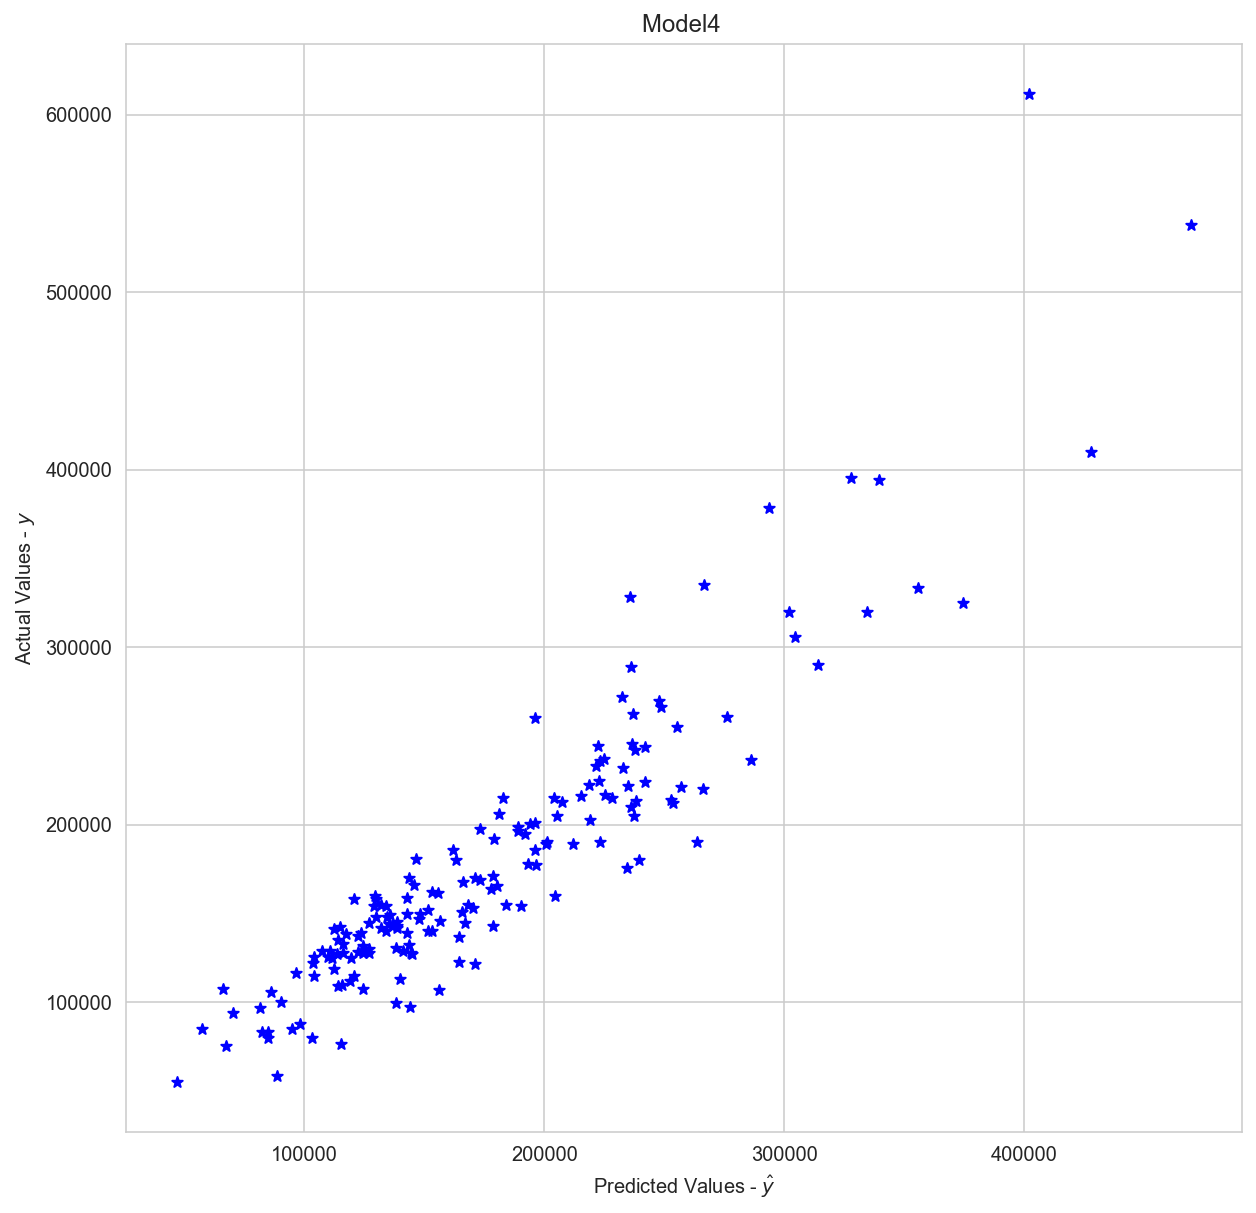

MSE: 965248715.6999388


In [57]:

plt.figure(figsize=(10,10))
plt.scatter(house_yhat, y_test, s=30, c='b', marker='*')
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values - $y$")
plt.title("Model4 ")
plt.show()

print("MSE:", mean_squared_error(y_test, house_yhat))

 - MSE is really high in this case because the MSE is based on target which is a large scale variable. 

/Applications/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:2477: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


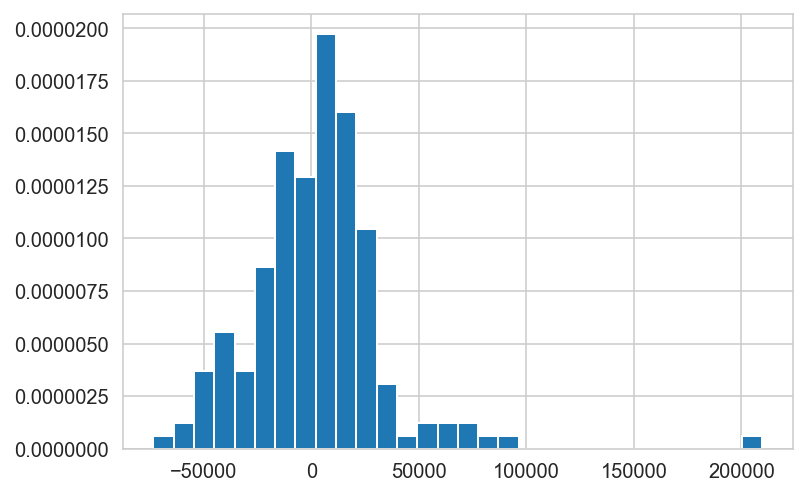

In [58]:
residuals = y_test - house_yhat
residuals.hist(normed=True,bins = 30)

## Model Results
- The model manages an accuracy of 85% with only 7 variables
- The residuals are quite evenly distributed and from the histogram you can see that a good majority of predictions fall within $20,000 of the actual price
- There are a few massive overpredictions that are skewing the total result
- This could potentially have been fixed by a stricter removal of outliers during EDA

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

## EDA of non-fixed variables
1. Dropping fixed featues as well as features that describe the sale
  
  * At this point, I will also drop Functional, Overall Quality and Condition as while they ARE changeable features, they are not specific enough to give a suggestion about what should be renovated in order to improve the sale price
  
 
2. Creation of new target variable
3. Fix datatypes
4. Dummy out categorical variables that may be useful
5. Create new variables that may be valuable
6. Investigate correlations

In [59]:
non_fixed = house.drop(['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','LotShape','LandContour','Utilities'
                       ,'LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType', 'HouseStyle', 
                       'HouseAge', 'RemodelAge', 'Foundation', 'BsmtExposure','TotalBsmtSF','BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                       'Heating', '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','Fireplaces',
                       'GarageType','GarageCars','GarageArea','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                       'ScreenPorch', 'PoolArea','YearBuilt','YearRemodAdd', 'GarageAge','GarageYrBlt', 'MoSold', 'YrSold', 'SaleType',
                        'SaleCondition','Id','OverallQual', 'OverallCond','Functional'], axis = 1)


##### Fitting the chosen model onto the whole data set to create the new target variable 'Residuals'

In [60]:
house_y = house['SalePrice']
house_X = house.drop(columns = 'SalePrice', axis = 1)
non_fixed['Residuals'] = house_y - model4.predict(house_X)

/Applications/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:2477: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


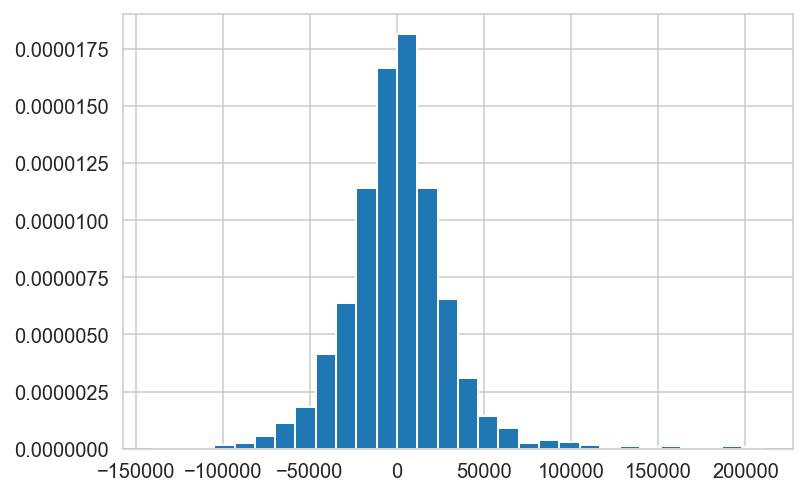

In [61]:
non_fixed['Residuals'].hist(normed=True,bins = 30)

###### Remove residuals above $150,000 so that the target is more evenly distributed

In [62]:
non_fixed = non_fixed[non_fixed['Residuals']<150000]

/Applications/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:2477: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


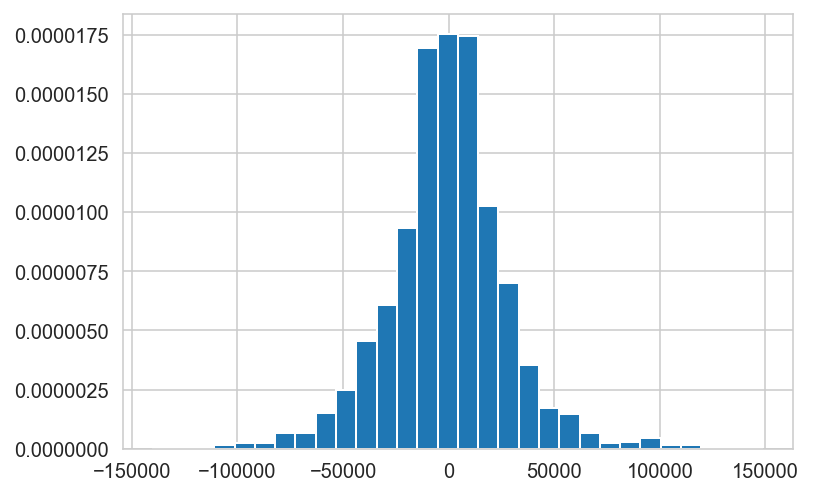

In [63]:
non_fixed['Residuals'].hist(normed=True,bins = 30)

In [64]:
non_fixed.head()

,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtHeight,BsmtCond,...,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MiscVal,SalePrice,Residuals
0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4,3,4,3,...,2,3,3,2,0,0,None,0,208500,8171.712880
1,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,3,4,3,...,2,3,3,2,0,0,None,0,181500,-27618.341113
2,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4,3,4,3,...,2,3,3,2,0,0,None,0,223500,2313.060637
3,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,3,3,3,4,...,1,3,3,2,0,0,None,0,140000,-50259.968731
4,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4,3,4,3,...,2,3,3,2,0,0,None,0,250000,-64889.891235


In [65]:
non_fixed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1437 entries, 0 to 1459
Data columns (total 32 columns):
RoofStyle       1437 non-null object
RoofMatl        1437 non-null object
Exterior1st     1437 non-null object
Exterior2nd     1437 non-null object
MasVnrType      1437 non-null object
MasVnrArea      1437 non-null float64
ExterQual       1437 non-null object
ExterCond       1437 non-null object
BsmtHeight      1437 non-null int64
BsmtCond        1437 non-null int64
BsmtFinType1    1437 non-null int64
BsmtFinType2    1437 non-null int64
HeatingQC       1437 non-null object
CentralAir      1437 non-null object
Electrical      1437 non-null object
FullBath        1437 non-null int64
HalfBath        1437 non-null int64
BedroomAbvGr    1437 non-null int64
KitchenAbvGr    1437 non-null int64
KitchenQual     1437 non-null object
TotRmsAbvGrd    1437 non-null int64
FireplaceQu     1437 non-null int64
GarageFinish    1437 non-null int64
GarageQual      1437 non-null int64
GarageCond      

##### Some of these features are still not in their ideal datatype and need to be changed to integers

In [66]:
#change to int64:
to_int = ['ExterQual','ExterCond', 'HeatingQC', 'Residuals', 'PoolQC', 'KitchenQual','MasVnrArea']
for o in to_int:
    non_fixed[o] = non_fixed[o].astype('int64')

##### Look at variation of last 8 object variables. When looking at these categorical variables, we want the different categories to have reasonably even amount of each, we also want to see that there is actually a difference in target across the categories

RoofStyle Counts: [1129, 276, 13, 10, 7, 2]
RoofMatl Counts: [1414, 11, 5, 4, 1, 1, 1]
Exterior1st Counts: [512, 220, 215, 201, 105, 60, 48, 26, 24, 19, 2, 2, 1, 1, 1]
Exterior2nd Counts: [501, 209, 204, 194, 139, 59, 38, 25, 23, 19, 9, 7, 5, 3, 1, 1]
MasVnrType Counts: [857, 443, 123, 14]
CentralAir Counts: [1348, 89]
Electrical Counts: [1316, 90, 27, 3, 1]
MiscFeature Counts: [1387, 45, 2, 2, 1]


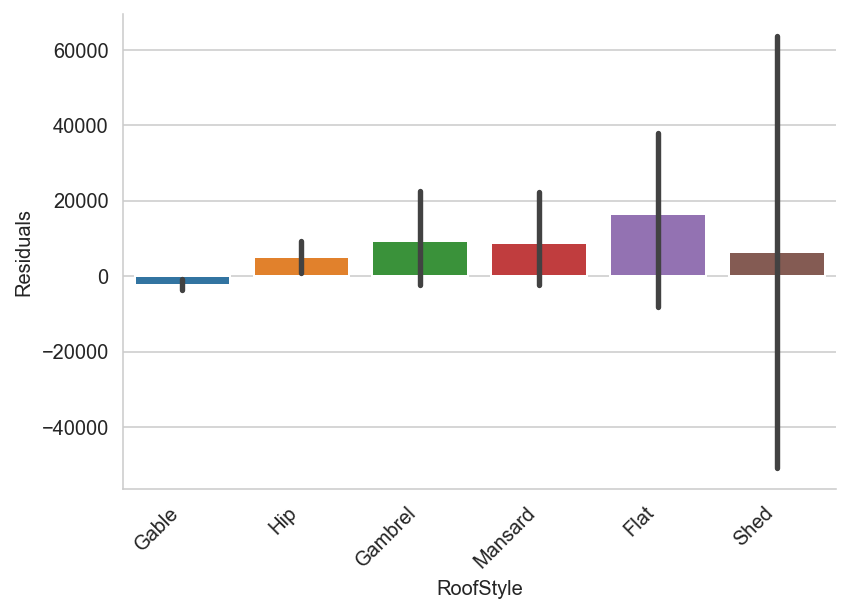

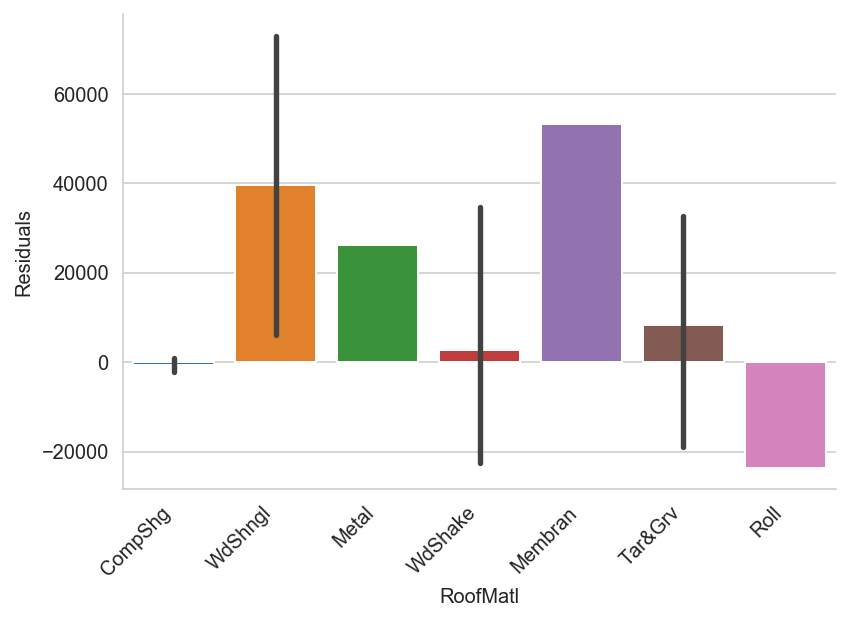

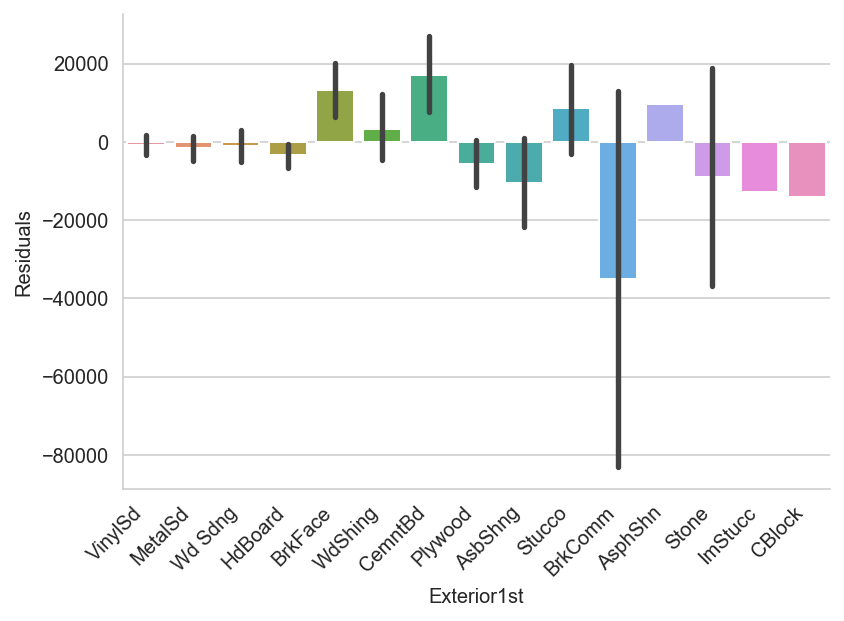

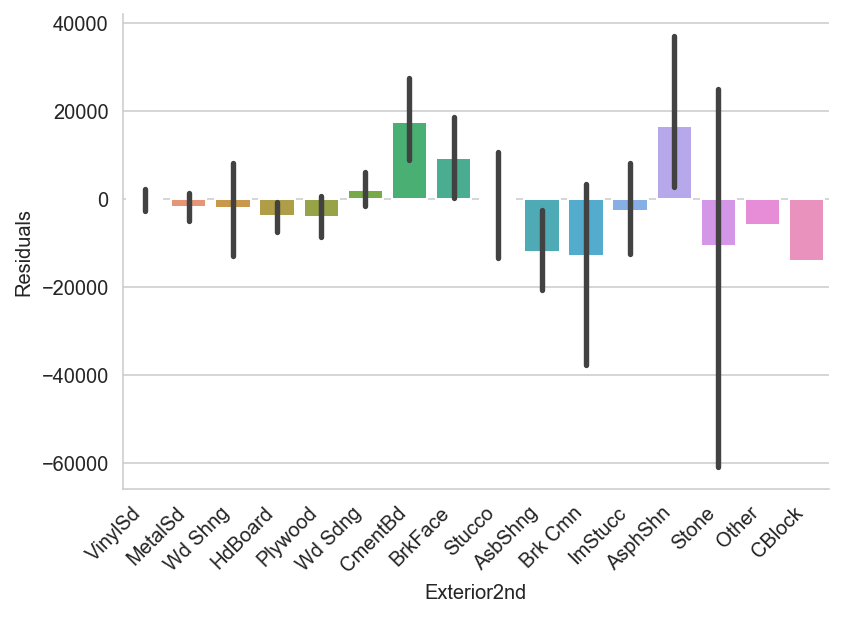

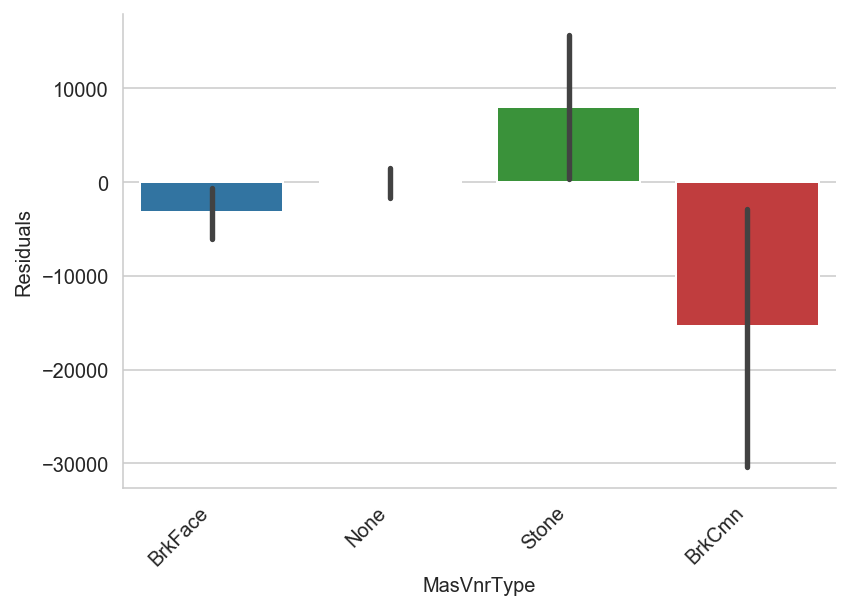

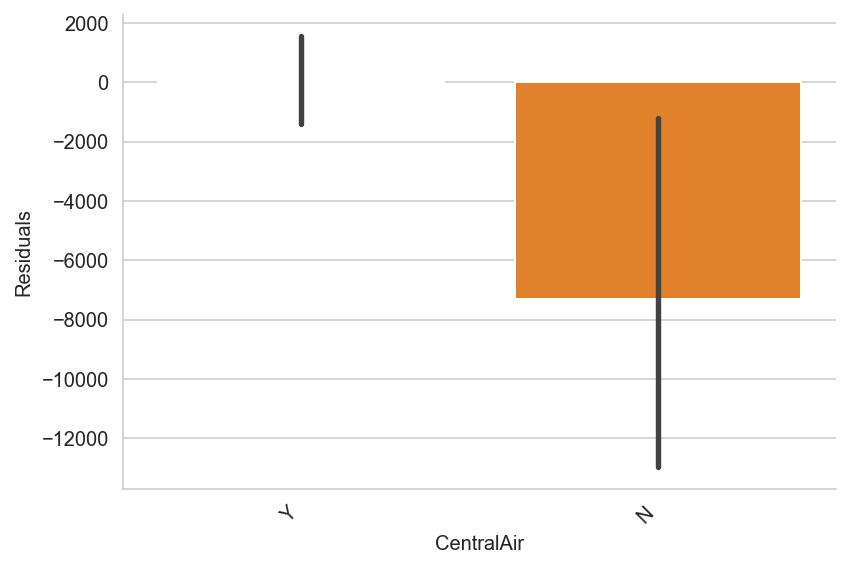

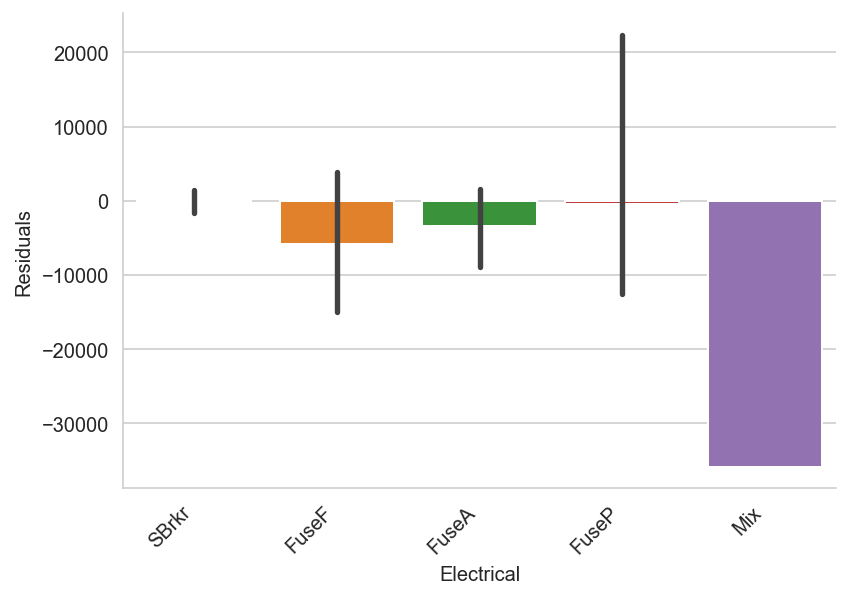

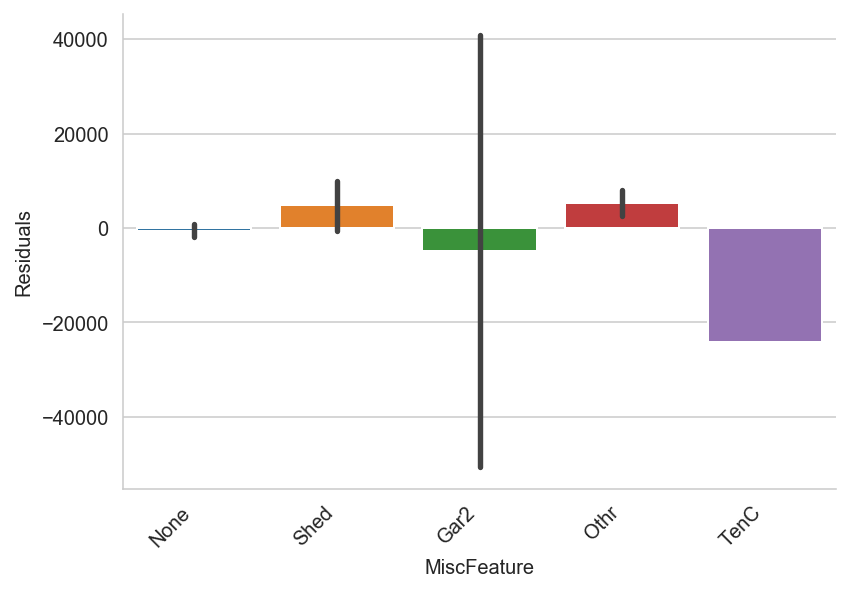

In [67]:
check_cats = ['RoofStyle','RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'CentralAir', 'Electrical','MiscFeature']

for a in check_cats:
    print(str(a)+' Counts:', list(non_fixed[a].value_counts()))
    ax = sns.catplot(x=a, y ='Residuals',data=non_fixed, kind='bar', height = 4, aspect = 1.5)
    ax.set_xticklabels(rotation=45, horizontalalignment='right')
    
#Make it the title of the ax to be able to have each one separately
    

- RoofStyle: not great variation, good variety in Residual affect
- RoofMatl: not enough variation, no point looking at comparison to Residual affect
- Exterior1st: good variation in both areas
- Exterior2nd: good variation in both areas
- MasVnrType: good variation in both areas, potentially dummy out then multiply with area?
- CentralAir: not great variation, good variety in Residuals, also seems like something that WOULD have an affect on price
- Electrical: not enough variation, no point looking at comparison to Residual affect
- MiscFeature: not enough variation, no point looking at comparison to Residual affect


##### Drop the columns that will not have any use

In [68]:
col_drop = ['RoofMatl', 'Electrical', 'MiscFeature']

for col in col_drop:
    non_fixed.drop(col, axis=1, inplace=True)

In [69]:
non_fixed.columns

Index(['RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'BsmtHeight', 'BsmtCond', 'BsmtFinType1',
       'BsmtFinType2', 'HeatingQC', 'CentralAir', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscVal', 'SalePrice', 'Residuals'],
      dtype='object')

##### Dummy out all the variables that may be useful in this model. In the case of MasVnrType, I have decided not to drop the first column so that all columns can be used to feature engineer a column that is type multiplied by the area


In [70]:
to_dummies = ['RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'CentralAir']

for col in to_dummies:
    dummies = pd.get_dummies(non_fixed[col], prefix = col)
    non_fixed.drop(col, axis=1, inplace=True)
    if col != 'MasVnrType':
        dummies = dummies.iloc[:,1:]
    else:    
        dummies.rename(columns = {'None':'No Veneer'}, inplace=True)
    non_fixed = pd.concat([non_fixed,dummies],axis = 1)   

In [71]:
len(non_fixed.columns)

63

##### Drop any columns that do not have senough variance in their value counts

In [72]:
low_var = []
for column in non_fixed.columns:
    if np.max(non_fixed[column].value_counts(normalize=True)) > 0.90:
        low_var.append(column)
                
non_fixed.drop(columns=low_var, inplace=True)
print("Dropped Columns: ", low_var)

Dropped Columns:  ['KitchenAbvGr', 'GarageCond', 'PavedDrive', 'PoolQC', 'MiscVal', 'RoofStyle_Gambrel', 'RoofStyle_Mansard', 'RoofStyle_Shed', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_ImStucc', 'Exterior1st_Plywood', 'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_WdShing', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_ImStucc', 'Exterior2nd_Other', 'Exterior2nd_Plywood', 'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_Wd Shng', 'MasVnrType_BrkCmn', 'MasVnrType_Stone', 'CentralAir_Y']


In [73]:
len(low_var)

32

In [74]:
multiply_by_area = list(non_fixed.filter(regex='MasVnrType',axis=1).columns)

for col in multiply_by_area:
    non_fixed[col] = non_fixed[col] * non_fixed['MasVnrArea']

In [75]:
non_fixed.drop(['MasVnrArea','SalePrice'], axis=1, inplace=True)


In [76]:
non_fixed.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1437 entries, 0 to 1459
Data columns (total 29 columns):
ExterQual              1437 non-null int64
ExterCond              1437 non-null int64
BsmtHeight             1437 non-null int64
BsmtCond               1437 non-null int64
BsmtFinType1           1437 non-null int64
BsmtFinType2           1437 non-null int64
HeatingQC              1437 non-null int64
FullBath               1437 non-null int64
HalfBath               1437 non-null int64
BedroomAbvGr           1437 non-null int64
KitchenQual            1437 non-null int64
TotRmsAbvGrd           1437 non-null int64
FireplaceQu            1437 non-null int64
GarageFinish           1437 non-null int64
GarageQual             1437 non-null int64
Fence                  1437 non-null int64
Residuals              1437 non-null int64
RoofStyle_Gable        1437 non-null uint8
RoofStyle_Hip          1437 non-null uint8
Exterior1st_HdBoard    1437 non-null uint8
Exterior1st_MetalSd    1437 non-n

##### Create new features:
- External Score
- Basement Score
- Garage Score
- Total Bathrooms

In [77]:
non_fixed['ExterScore'] = non_fixed['ExterQual'] * non_fixed['ExterCond']
non_fixed['BsmtScore'] = non_fixed['BsmtCond'] * non_fixed['BsmtFinType1'] * non_fixed['BsmtFinType2']
non_fixed['GarageScore'] = non_fixed['GarageFinish'] * non_fixed['GarageQual']
non_fixed['Bathrooms'] = non_fixed['FullBath'] + non_fixed['HalfBath']*0.5

In [78]:
# corr = dict()
corr = dict(non_fixed.corrwith(non_fixed['Residuals']).sort_values(ascending=False))
corr

{'Residuals': 1.0,
 'BsmtFinType1': 0.1707256994459149,
 'KitchenQual': 0.16267762167614477,
 'ExterScore': 0.13657834045414577,
 'BsmtScore': 0.11375074636031673,
 'ExterQual': 0.09751747345919823,
 'ExterCond': 0.0952918975463679,
 'RoofStyle_Hip': 0.09474486877225076,
 'HeatingQC': 0.08180543816375148,
 'GarageScore': 0.07806174287112076,
 'GarageFinish': 0.07482008329791859,
 'Fence': 0.037828587351786555,
 'Exterior2nd_Wd Sdng': 0.03563595708239583,
 'Exterior2nd_VinylSd': 0.005329321702268285,
 'MasVnrType_None': -0.0019599893343105923,
 'BsmtFinType2': -0.006000091990144649,
 'GarageQual': -0.007350207091082905,
 'Exterior1st_VinylSd': -0.008605699582969684,
 'Exterior1st_Wd Sdng': -0.009150463275947623,
 'Exterior1st_MetalSd': -0.017322256804158668,
 'Exterior2nd_MetalSd': -0.02115494769482295,
 'FireplaceQu': -0.024614315901430036,
 'BsmtHeight': -0.033893039262052456,
 'HalfBath': -0.043192175721063,
 'Exterior1st_HdBoard': -0.04419439528253878,
 'Exterior2nd_HdBoard': -0.047

##### The correlation scores here are not good so I will only eliminate those between - 0.05 and 0.05

In [79]:
non_fixed_corr = pd.DataFrame(data = [non_fixed[k] for k,v in corr.items() if v>0.05 or v<-.05]).T
non_fixed_corr.head()

,Residuals,BsmtFinType1,KitchenQual,ExterScore,BsmtScore,ExterQual,ExterCond,RoofStyle_Hip,HeatingQC,GarageScore,GarageFinish,BsmtCond,MasVnrType_BrkFace,FullBath,Bathrooms,TotRmsAbvGrd,RoofStyle_Gable,BedroomAbvGr
0,8171.0,6.0,4.0,12.0,18.0,4.0,3.0,0.0,5.0,6.0,2.0,3.0,196.0,2.0,2.5,8.0,1.0,3.0
1,-27618.0,5.0,3.0,9.0,15.0,3.0,3.0,0.0,5.0,6.0,2.0,3.0,0.0,2.0,2.0,6.0,1.0,3.0
2,2313.0,6.0,4.0,12.0,18.0,4.0,3.0,0.0,5.0,6.0,2.0,3.0,162.0,2.0,2.5,6.0,1.0,3.0
3,-50259.0,5.0,4.0,9.0,20.0,3.0,3.0,0.0,4.0,3.0,1.0,4.0,0.0,1.0,1.0,7.0,1.0,3.0
4,-64889.0,6.0,4.0,12.0,18.0,4.0,3.0,0.0,5.0,6.0,2.0,3.0,350.0,2.0,2.5,9.0,1.0,4.0


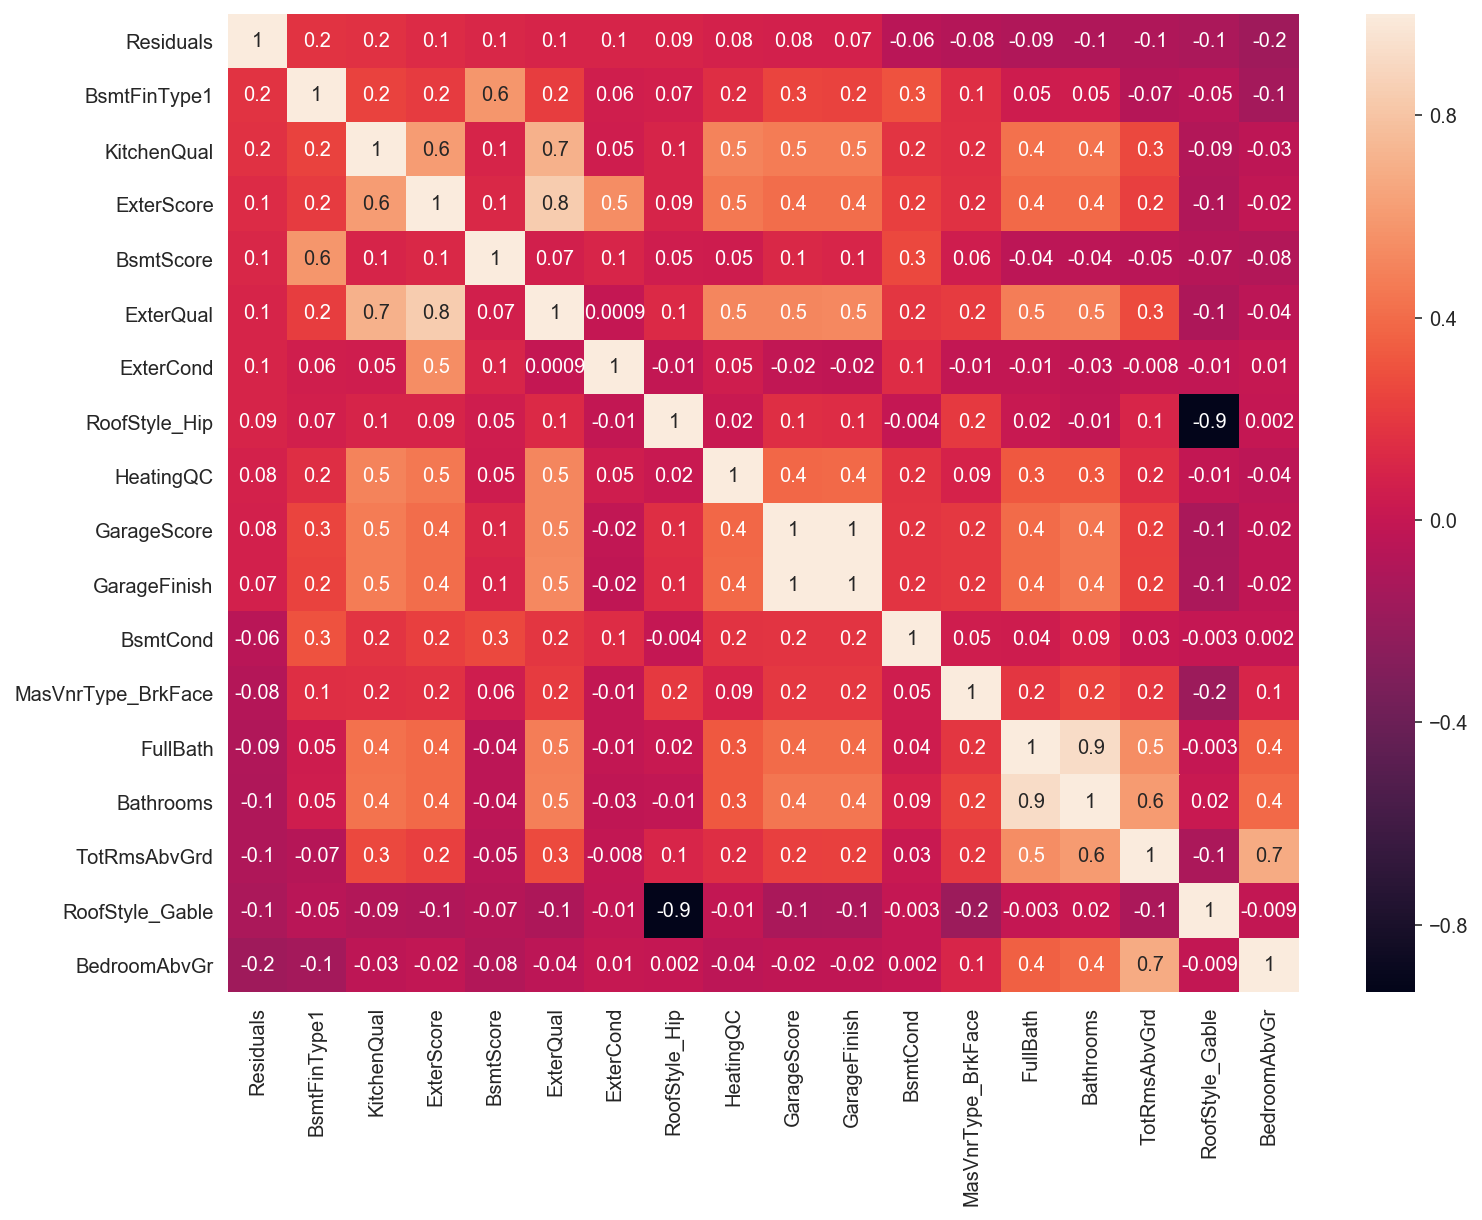

In [80]:
plt.figure(figsize=(12, 9))
sns.heatmap(non_fixed_corr.corr(), annot=True, fmt='0.1g')

##### Drop:
- BsmtFinType1 as it is highly correlated with BsmtScore but lower correlation with Residuals
- ExterScore and ExterQual as it is highly correlated with ExterCond and KitchenQual
- GarageFinish as it is highly correlated with GarageScore
- TotRmsAbvGrd as it is highly correlated with BedroomAbvGr
- Bathrooms as it is highly correlated with FullBath

In [81]:
non_fixed_var = non_fixed_corr.drop(columns= ['BsmtFinType1','ExterScore','ExterQual','GarageFinish',
                                              'TotRmsAbvGrd','Bathrooms'],axis=1)

##### Creation of target and prediction matrices

In [82]:
NFX = non_fixed_var.drop(['Residuals'],axis=1)
NFy = non_fixed_var['Residuals'].ravel()
NFX.head()

,KitchenQual,BsmtScore,ExterCond,RoofStyle_Hip,HeatingQC,GarageScore,BsmtCond,MasVnrType_BrkFace,FullBath,RoofStyle_Gable,BedroomAbvGr
0,4.0,18.0,3.0,0.0,5.0,6.0,3.0,196.0,2.0,1.0,3.0
1,3.0,15.0,3.0,0.0,5.0,6.0,3.0,0.0,2.0,1.0,3.0
2,4.0,18.0,3.0,0.0,5.0,6.0,3.0,162.0,2.0,1.0,3.0
3,4.0,20.0,3.0,0.0,4.0,3.0,4.0,0.0,1.0,1.0,3.0
4,4.0,18.0,3.0,0.0,5.0,6.0,3.0,350.0,2.0,1.0,4.0


In [83]:
NFy

array([  8171., -27618.,   2313., ...,  17856.,  27344.,   7039.])

## Modelling
1. Scale variables for feature selection models
2. Trial different types of feature selection to find a model with the best fit
3. Plot and evaluate final model


In [84]:
#Scaling variables for feature selection 
ss = StandardScaler()
NFXs = ss.fit_transform(NFX.values)
print(NFXs.mean(), NFXs.std())

-5.933551029311901e-17 0.9999999999999997


In [85]:
#splitting out for training
NFX_train, NFX_test, NFy_train, NFy_test = train_test_split(NFXs, NFy, test_size=0.2)

In [86]:
#trial of Lasso

lasso = LassoCV(n_alphas=500, cv=10, verbose=1)

model = lasso.fit(NFX_train, NFy_train)

lasso.score(NFX_test, NFy_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.14394995057741633

In [87]:
lasso_coefs = pd.DataFrame({'variable':pd.DataFrame(NFX).columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
9,RoofStyle_Gable,-5846.372763,5846.372763
0,KitchenQual,5292.914082,5292.914082
8,FullBath,-4360.181824,4360.181824
6,BsmtCond,-4016.249275,4016.249275
3,RoofStyle_Hip,-3223.320643,3223.320643
1,BsmtScore,3031.619007,3031.619007
7,MasVnrType_BrkFace,-2669.112630,2669.112630
10,BedroomAbvGr,-2298.589421,2298.589421
2,ExterCond,1742.729816,1742.729816
5,GarageScore,1433.933790,1433.933790


In [88]:
NFy_hat = lasso.predict(NFX_test)

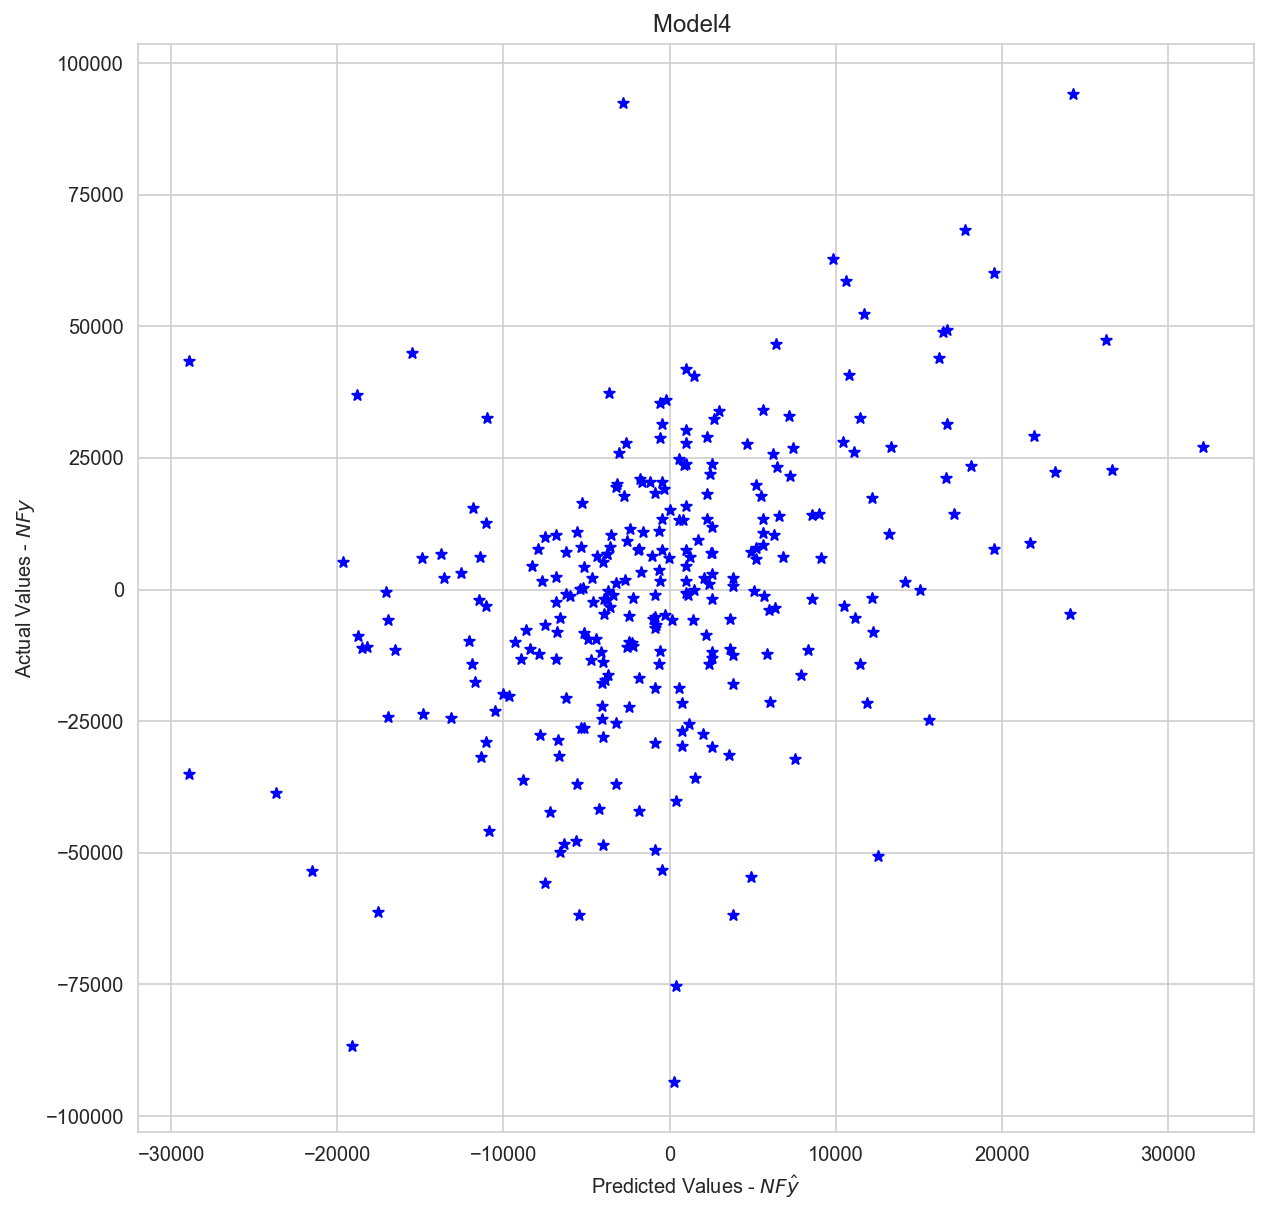

MSE: 602783486.7226036


In [89]:
# Plot the model
plt.figure(figsize=(10,10))
plt.scatter(NFy_hat, NFy_test, s=30, c='b', marker='*')
plt.xlabel("Predicted Values - $NF\hat{y}$")
plt.ylabel("Actual Values - $NFy$")
plt.title("Model4 ")
plt.show()

print("MSE:", mean_squared_error(NFy_test, NFy_hat))

In [90]:
a = np.logspace(0, 5, 200)

ridge = RidgeCV(alphas = a, cv=10)

model = ridge.fit(NFX_train, NFy_train)

ridge.score(NFX_test, NFy_test)

0.14160601906763948

## Model Results
- I have only been able to create a model that manages to predict the residuals 14.4% better than the baseline model
- From the Lasso'd coefficients, we can see the best features to improve would be the roof, kitchen, basement and building additional bathrooms.
- Suggestion to the real eastate company would be to calculate the costs of the following renovations and compare to price increase:

      * Change RoofStyle to Gable = $5,846 (Highly unlikely to be profitable)
      * Additional Quality Point to Kitchen = $5,292 (Possible)
      * Add in a bathroom = $4,360 (Possible)
      * Additional Condition Point to Basement = $4,016 (Potentially Cheapest)
      * Change RoofStyle to Hip = $3223 (Highly unlikely to be profitable)
      * Update Masonry Veneer to Brick = $2,669 (Highly unlikely to be profitable)
      * Additional Bedroom Above Ground = $2,298 (Highly unlikely to be profitable)
      * Improve Exterior Condition by one point = $1,743
      * Improve Garage Score by one point = $1434
      * Improve Heating Quality by one point = $1,261
